In [1]:
import numpy as np
from scipy import signal
from scipy.io.wavfile import read
from IPython.display import Audio
import matplotlib.pyplot as plt
from numpy.fft import fft

In [2]:
def downsample_4k(data, fs):
    return signal.resample_poly(data, 1, 11)

def bandpass(data):
    b = signal.firls(25, [0, 250, 300, 2000], [0, 0, 1, 1], fs=4000)
    w, h = signal.freqz(b)
    plt.plot(w, 20*np.log10(abs(h)))
    return signal.lfilter(b, 1, data)

def stft(data, win_len=100, win_overlap=10):
    frame_start = 0
    
    win_len_frames = 4000 * win_len // 1000
    win_overlap_frames = 4000 * win_overlap // 1000
    
    num_frames = data.shape[0] // win_overlap_frames
    print(data.shape)
    print(num_frames)

    stft_out = np.zeros((num_frames, win_len_frames//2))
    frame = np.zeros(win_len_frames)
    fft_frame = np.zeros(win_len_frames)
    
    for i in range(num_frames):
        frame_start = i * win_overlap_frames
        win = np.hamming(win_len_frames)
        if frame_start + win_len_frames >= data.shape[0]:
            frame[0:data.shape[0]-frame_start] = data[frame_start:]
            frame = frame * win
        else:
            frame = win * data[frame_start : frame_start + win_len_frames]
        fft_frame = abs(fft(frame))
        stft_out[i,:] = np.square(np.abs(fft_frame[:win_len_frames//2])) / win_len_frames
            
    return stft_out

def compute_mel(data, nbins=18):
    low_mfreq = 0
    hi_mfreq = 2595 * np.log10(1 + 2000/700)
    m_points = np.linspace(low_mfreq, hi_mfreq, nbins + 2)
    hz_points = (700 * (10**(m_points / 2595) - 1))
    
    bin = (4000*100//1000 + 1) * hz_points / 4000
    f_bank = np.zeros((nbins, 4000*100//1000 // 2))
    
    for m in range(1, nbins + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            f_bank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            f_bank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    f_bank = np.where(f_bank < 0, 0, f_bank)

    filter_banks = np.dot(data, f_bank.T)
    filter_banks = np.where(filter_banks <= 0, np.finfo(float).eps, filter_banks)
    return 20 * np.log10(filter_banks)

def find_peaks(data):
    print(data.shape)

In [3]:
fs, data = read('test_songs/Bone.wav')
if (data.shape[1] != 1):
    data = data[:,0]
print(fs)
print(data.shape)

44100
(12781440,)


(12781440,)
(1161950,)


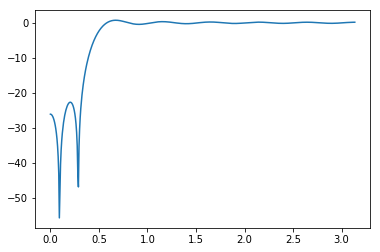

In [4]:
# apply downsampling
data_2 = downsample_4k(data, fs)
print(data.shape)
print(data_2.shape)
# apply bandpass
data_3 = bandpass(data_2)

(1161950,)
29048


/home/evan/ece420/ece420/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


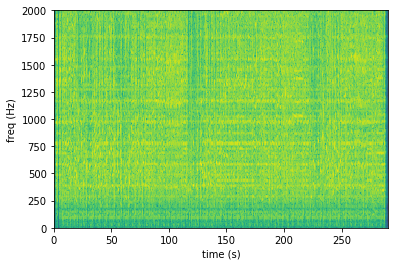

In [5]:
# compute stft

stft_out = stft(data_3)

scales = [np.linspace(0, data_3.size/4000, stft_out.shape[0]+1), np.linspace(0, 4000/2, stft_out.shape[1]+1)]

plt.figure()
plt.pcolormesh(scales[0], scales[1], 20*np.log10(stft_out.T))
plt.xlabel('time (s)')
plt.ylabel('freq (Hz)')
plt.axis('tight')
plt.show()

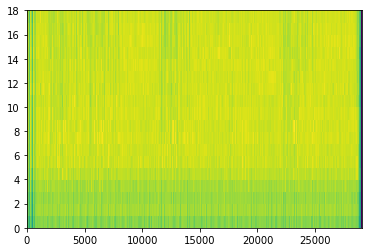

In [6]:
# apply mel filter bank

mels = compute_mel(stft_out)
plt.pcolormesh(mels.T)
plt.show()

In [11]:
peaks = [[] for i in range(mels.shape[1])]
print(peaks)

for t in range(9, mels.shape[0]-9):
    for b in range(1, mels.shape[1]-1):
        # test neighbors
        if mels[t,b] <= mels[t-1][b]:
            continue
        if mels[t,b] <= mels[t+1][b]:
            continue
        if mels[t,b] <= mels[t][b-1]:
            continue
        if mels[t,b] <= mels[t][b+1]:
            continue
            
        # add peak if it's the first one in band
        # if len(peaks[b]) == 0 or True:
        peaks[b].append(t)
        continue
            
        # check threshold
        # skip for now
        
        # compute region values
        # region 1
        r_1a = (mels[t-9][b] + mels[t-8][b] + mels[t-7][b]) / 3
        r_1b = (mels[t-7][b] + mels[t-6][b] + mels[t-5][b]) / 3
        r_1c = (mels[t-5][b] + mels[t-4][b] + mels[t-3][b]) / 3
        r_1d = (mels[t-3][b] + mels[t-2][b] + mels[t-1][b]) / 3
        r_1e = (mels[t+1][b] + mels[t-2][b] + mels[t-3][b]) / 3
        r_1f = (mels[t+3][b] + mels[t-4][b] + mels[t-5][b]) / 3
        r_1g = (mels[t+5][b] + mels[t-6][b] + mels[t-7][b]) / 3
        r_1h = (mels[t+7][b] + mels[t-8][b] + mels[t-8][b]) / 3
        
        # region 2
        if b == mels.shape[1] - 1:
            r_2a = (mels[t-1][b+1] + mels[t][b+1] + mels[t+1][b+1]) / 3
        else:
            r_2a = (mels[t-1][b+2] + mels[t][b+2] + mels[t+1][b+2]) / 3
        r_2b = (mels[t-1][b+1] + mels[t][b+1] + mels[t+1][b+1]) / 3
        r_2c = (mels[t-1][b-1] + mels[t][b-1] + mels[t+1][b-1]) / 3
        if b == 1:
            r_2d = (mels[t-1][b-1] + mels[t][b-1] + mels[t+1][b-1]) / 3
        else:
            r_2d = (mels[t-1][b-2] + mels[t][b-2] + mels[t+1][b-2]) / 3
            
        # region 3
        r_3a = (mels[t-2][b+1] + mels[t-1][b+1] + mels[t][b+1] + mels[t-2][b] + mels[t-1][b]) / 5
        r_3b = (mels[t][b+1] + mels[t+1][b+1] + mels[t+2][b+1] + mels[t+1][b] + mels[t+2][b]) / 5
        r_3c = (mels[t+1][b] + mels[t+2][b] + mels[t][b-1] + mels[t+1][b-1] + mels[t+2][b-1]) / 5
        r_3d = (mels[t-2][b] + mels[t-1][b] + mels[t-2][b-1] + mels[t-1][b-1] + mels[t][b-1]) / 5
        
        # region 4
        if b == mels.shape[1] - 1:
            r_4a = (mels[t-9][b+1] + mels[t-8][b+1] + mels[t-7][b+1] + mels[t-6][b+1]) / 4
            r_4b = (mels[t-5][b+1] + mels[t-4][b+1] + mels[t-3][b+1] + mels[t-2][b+1]) / 4
            r_4e = (mels[t+5][b+1] + mels[t+4][b+1] + mels[t+3][b+1] + mels[t+2][b+1]) / 4
            r_4f = (mels[t+9][b+1] + mels[t+8][b+1] + mels[t+7][b+1] + mels[t+6][b+1]) / 4
        else:
            r_4a = (mels[t-9][b+2] + mels[t-8][b+2] + mels[t-7][b+2] + mels[t-6][b+2] + mels[t-9][b+1] + mels[t-8][b+1] + mels[t-7][b+1] + mels[t-6][b+1]) / 8
            r_4b = (mels[t-5][b+2] + mels[t-4][b+2] + mels[t-3][b+2] + mels[t-2][b+2] + mels[t-5][b+1] + mels[t-4][b+1] + mels[t-3][b+1] + mels[t-2][b+1]) / 8
            r_4e = (mels[t+5][b+2] + mels[t+4][b+2] + mels[t+3][b+2] + mels[t+2][b+2] + mels[t+5][b+1] + mels[t+4][b+1] + mels[t+3][b+1] + mels[t+2][b+1]) / 8
            r_4f = (mels[t+9][b+2] + mels[t+8][b+2] + mels[t+7][b+2] + mels[t+6][b+2] + mels[t+9][b+1] + mels[t+8][b+1] + mels[t+7][b+1] + mels[t+6][b+1]) / 8
        if b = 1:
            r_4c = (mels[t-9][b-1] + mels[t-8][b-1] + mels[t-7][b-1] + mels[t-6][b-1]) / 4
            r_4d = (mels[t-5][b-1] + mels[t-4][b-1] + mels[t-3][b-1] + mels[t-2][b-1]) / 4
            r_4g = (mels[t+5][b-1] + mels[t+4][b-1] + mels[t+3][b-1] + mels[t+2][b-1]) / 4
            r_4h = (mels[t+9][b-1] + mels[t+8][b-1] + mels[t+7][b-1] + mels[t+6][b-1]) / 4
        else:
            r_4a = (mels[t-9][b-2] + mels[t-8][b-2] + mels[t-7][b-2] + mels[t-6][b-2] + mels[t-9][b-1] + mels[t-8][b-1] + mels[t-7][b-1] + mels[t-6][b-1]) / 8
            r_4b = (mels[t-5][b-2] + mels[t-4][b-2] + mels[t-3][b-2] + mels[t-2][b-2] + mels[t-5][b-1] + mels[t-4][b-1] + mels[t-3][b-1] + mels[t-2][b-1]) / 8
            r_4e = (mels[t+5][b-2] + mels[t+4][b-2] + mels[t-3][b-2] + mels[t+2][b-2] + mels[t+5][b-1] + mels[t+4][b-1] + mels[t+3][b-1] + mels[t+2][b-1]) / 8
            r_4f = (mels[t+9][b-2] + mels[t+8][b-2] + mels[t+7][b-2] + mels[t+6][b-2] + mels[t+9][b-1] + mels[t+8][b-1] + mels[t+7][b-1] + mels[t+6][b-1]) / 8




        

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [13]:
num_peaks = 0
for b in peaks:
    num_peaks += len(b)
    print(len(b))
print(num_peaks)

0
2461
86
98
327
1459
777
1348
670
1407
593
1312
560
1412
919
1059
1010
0
15498
